In [92]:
import os
import math
from glob import glob
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.utils.class_weight import compute_sample_weight
import matplotlib.pyplot as plt
from scipy.stats import expon
import seaborn as sns

In [82]:
observations = pd.read_csv('data/n100_final_data.csv', parse_dates=['date'])
covariates = pd.read_csv('data/covariates.csv', parse_dates=['date'])

stations = ['SGP', 'EGB', 'AMA', 'SAO']

observations = observations[observations.station.isin(stations)]
covariates = covariates[covariates.station.isin(stations)]

observations.reset_index(inplace=True, drop=True)
covariates.reset_index(inplace=True, drop=True)

aerosols = ['aermr01', 'aermr02', 'aermr03', 'aermr04', 'aermr05', 'aermr06', 
            'aermr07', 'aermr08', 'aermr09', 'aermr10', 'aermr11']

gases = ['co', 'c5h8', 'c10h16', 'nh3', 'no', 'no2', 'so2']

met = ['d2m', 't2m', 'blh', 'rh', 'wind_speed', 'crwc']
        
loc = ['latitude', 'longitude']

feature_list = gases + met + aerosols + loc

log_transform = aerosols + gases + ['crwc']

# log-transforming the selected variables, setting negative values to the minimum observed positive value
for v in log_transform:
    covariates[v] = np.log(covariates[v].where(covariates[v] > 0, covariates[v][covariates[v] > 0].min()))

In [83]:
observations.head()

,date,station,n100,interpolated
0,2015-01-08 17:54:00,AMA,307.12,False
1,2015-01-08 18:00:00,AMA,384.20,False
2,2015-01-08 18:05:00,AMA,402.09,False
3,2015-01-08 18:09:00,AMA,393.27,False
4,2015-01-08 18:14:00,AMA,383.32,False


In [84]:
covariates.head()

,station,date,latitude,longitude,aermr01,aermr02,aermr03,aermr04,aermr05,aermr06,...,nh3,no,no2,so2,d2m,t2m,crwc,blh,rh,wind_speed
0,AMA,2015-01-01 00:00:00,-2.146,-59.006,-24.598146,-20.263395,-21.256043,-19.414456,-19.168248,-22.876638,...,-23.299665,-26.159742,-22.038885,-24.663730,296.99567,299.56116,-21.2365,22.364786,85.828671,0.415075
1,AMA,2015-01-01 03:00:00,-2.146,-59.006,-25.130594,-20.798726,-21.177092,-19.447359,-19.391981,-22.988089,...,-22.818206,-26.075859,-21.403201,-24.208618,296.94850,298.57170,-21.2365,19.715347,90.749997,0.525585
2,AMA,2015-01-01 06:00:00,-2.146,-59.006,-25.390514,-21.056049,-21.215057,-19.472880,-19.539301,-22.935515,...,-22.859138,-26.154351,-21.243397,-24.361424,296.00793,297.68330,-21.2365,21.392578,90.405100,0.616981
3,AMA,2015-01-01 09:00:00,-2.146,-59.006,-24.827318,-20.489230,-21.297031,-19.754914,-19.599997,-22.612200,...,-23.298816,-27.159208,-21.832110,-25.882275,296.40344,297.72556,-21.2365,31.333725,92.360527,0.559924
4,AMA,2015-01-01 12:00:00,-2.146,-59.006,-23.023376,-18.660515,-20.157377,-18.550221,-18.343114,-21.104295,...,-23.404071,-25.620457,-23.181360,-25.559504,296.63824,300.29105,-21.2365,220.510540,80.469814,0.702493


In [85]:
observations = observations.dropna(axis=0)
observations.reset_index(inplace=True, drop=True)

In [86]:
# calculate time difference between consecutive rows
observations['time_diff'] = observations.groupby('station')['date'].diff()

# calculate mode time difference for each station
# mode_diff = observations.groupby('station')['time_diff'].apply(lambda x: x.mode().iloc[0])

# function to find rows where time difference is greater than mode time difference
def find_gaps(group):
    station = group.name
    return group['time_diff'] > pd.Timedelta(hours=1, minutes=5) # + mode_diff[station]

gap_rows = observations.groupby('station').apply(find_gaps).reset_index(level=0, drop=True)

# create a new segment every time a gap is detected
segment_ids = gap_rows.groupby(observations['station']).cumsum()

# Reset the index on segment_ids
segment_ids = segment_ids.reset_index(level=0, drop=True)

# create group_ids column by concatenating station name and segment_ids
observations['group_ids'] = observations['station'] + '_segment_' + segment_ids.astype(str)

observations = observations[['date', 'n100', 'station', 'group_ids']]

In [89]:
observations.head()

,date,n100,station,group_ids
0,2015-01-08 17:54:00,307.12,AMA,AMA_segment_0
1,2015-01-08 18:00:00,384.20,AMA,AMA_segment_0
2,2015-01-08 18:05:00,402.09,AMA,AMA_segment_0
3,2015-01-08 18:09:00,393.27,AMA,AMA_segment_0
4,2015-01-08 18:14:00,383.32,AMA,AMA_segment_0


In [88]:
observations.groupby('station')['group_ids'].nunique()

station
AMA     123
EGB      31
SAO      52
SGP    2212
Name: group_ids, dtype: int64

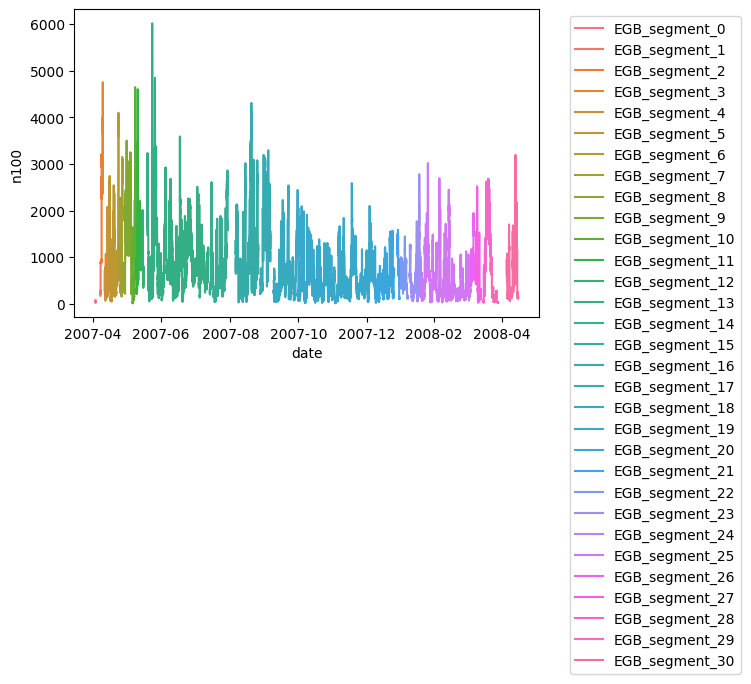

In [78]:
# Filter the data for station ZOT
filtered_data = observations[observations.station == 'EGB']

# Create the plot
plt.figure(figsize=(6, 4))
sns.lineplot(data=filtered_data, x='date', y='n100', hue='group_ids')

# Place the legend to the right of the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()

In [79]:
# group by station and group_ids, and calculate the length of each segment
segment_lengths = observations.groupby(['station', 'group_ids']).size()

# calculate time difference between consecutive rows
time_diff = observations.groupby('station')['date'].diff()

# filter for rows where time difference is greater than 3 hours
gap_lengths = time_diff[time_diff > pd.Timedelta(hours=1, minutes=5)]

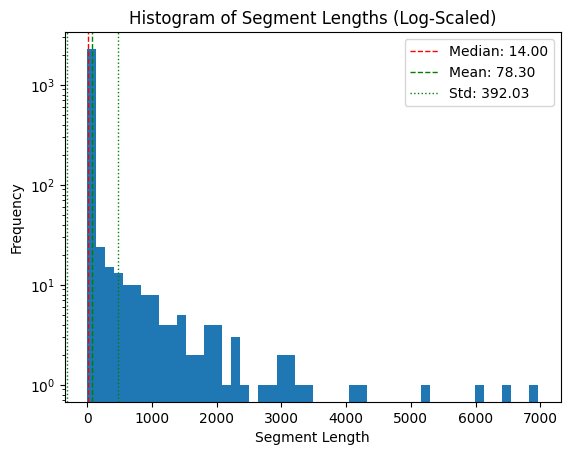

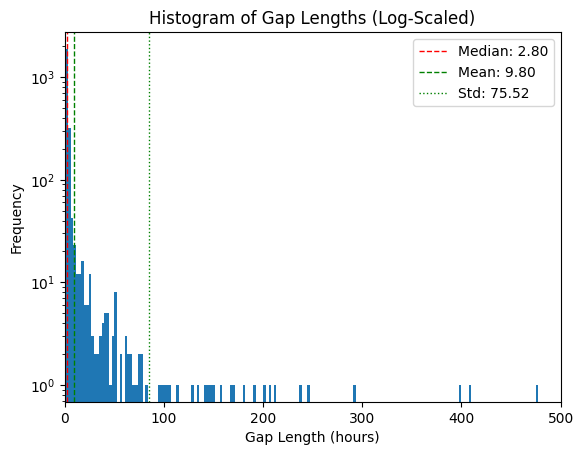

In [80]:
# calculate median, mean, and std for segment lengths
segment_median = np.median(segment_lengths)
segment_mean = np.mean(segment_lengths)
segment_std = np.std(segment_lengths)

# create histogram of segment lengths with median, mean, and std plotted
plt.hist(segment_lengths, bins=50, log=True)
plt.xlabel('Segment Length')
plt.ylabel('Frequency')
plt.title('Histogram of Segment Lengths (Log-Scaled)')
plt.axvline(segment_median, color='r', linestyle='dashed', linewidth=1)
plt.axvline(segment_mean, color='g', linestyle='dashed', linewidth=1)
plt.axvline(segment_mean + segment_std, color='g', linestyle='dotted', linewidth=1)
plt.axvline(segment_mean - segment_std, color='g', linestyle='dotted', linewidth=1)
plt.legend(['Median: {:.2f}'.format(segment_median), 'Mean: {:.2f}'.format(segment_mean), 'Std: {:.2f}'.format(segment_std)])
plt.show()

# calculate median, mean, and std for gap lengths
gap_median = np.median(gap_lengths / pd.Timedelta(hours=1))
gap_mean = np.mean(gap_lengths / pd.Timedelta(hours=1))
gap_std = np.std(gap_lengths / pd.Timedelta(hours=1))

# create histogram of gap lengths with median, mean, and std plotted
plt.hist(gap_lengths / pd.Timedelta(hours=1), bins=1000, log=True)
plt.xlabel('Gap Length (hours)')
plt.ylabel('Frequency')
plt.title('Histogram of Gap Lengths (Log-Scaled)')
plt.axvline(gap_median, color='r', linestyle='dashed', linewidth=1)
plt.axvline(gap_mean, color='g', linestyle='dashed', linewidth=1)
plt.axvline(gap_mean + gap_std, color='g', linestyle='dotted', linewidth=1)
plt.axvline(gap_mean - gap_std, color='g', linestyle='dotted', linewidth=1)
plt.legend(['Median: {:.2f}'.format(gap_median), 'Mean: {:.2f}'.format(gap_mean), 'Std: {:.2f}'.format(gap_std)])
plt.xlim([0, 500])
plt.show()

In [91]:
observations.head()

,date,n100,station,group_ids
0,2015-01-08 17:54:00,307.12,AMA,AMA_segment_0
1,2015-01-08 18:00:00,384.20,AMA,AMA_segment_0
2,2015-01-08 18:05:00,402.09,AMA,AMA_segment_0
3,2015-01-08 18:09:00,393.27,AMA,AMA_segment_0
4,2015-01-08 18:14:00,383.32,AMA,AMA_segment_0


In [90]:
covariates.head()

,station,date,latitude,longitude,aermr01,aermr02,aermr03,aermr04,aermr05,aermr06,...,nh3,no,no2,so2,d2m,t2m,crwc,blh,rh,wind_speed
0,AMA,2015-01-01 00:00:00,-2.146,-59.006,-24.598146,-20.263395,-21.256043,-19.414456,-19.168248,-22.876638,...,-23.299665,-26.159742,-22.038885,-24.663730,296.99567,299.56116,-21.2365,22.364786,85.828671,0.415075
1,AMA,2015-01-01 03:00:00,-2.146,-59.006,-25.130594,-20.798726,-21.177092,-19.447359,-19.391981,-22.988089,...,-22.818206,-26.075859,-21.403201,-24.208618,296.94850,298.57170,-21.2365,19.715347,90.749997,0.525585
2,AMA,2015-01-01 06:00:00,-2.146,-59.006,-25.390514,-21.056049,-21.215057,-19.472880,-19.539301,-22.935515,...,-22.859138,-26.154351,-21.243397,-24.361424,296.00793,297.68330,-21.2365,21.392578,90.405100,0.616981
3,AMA,2015-01-01 09:00:00,-2.146,-59.006,-24.827318,-20.489230,-21.297031,-19.754914,-19.599997,-22.612200,...,-23.298816,-27.159208,-21.832110,-25.882275,296.40344,297.72556,-21.2365,31.333725,92.360527,0.559924
4,AMA,2015-01-01 12:00:00,-2.146,-59.006,-23.023376,-18.660515,-20.157377,-18.550221,-18.343114,-21.104295,...,-23.404071,-25.620457,-23.181360,-25.559504,296.63824,300.29105,-21.2365,220.510540,80.469814,0.702493


In [ ]:
def create_gaps(s, gap_size):
    # Choose a random index to start the gap
    start = np.random.choice(range(len(s) - gap_size))
    # Create a boolean mask where the gap is represented by False
    mask = np.ones(len(s), dtype=bool)
    mask[start:start + gap_size] = False
    return mask

# Define the sequence length
sequence_length = pd.Timedelta(hours=72)

# Loop over each unique group
for group_id in tqdm(observations.group_ids.unique(), desc='Processing groups'):
    group_data = observations[observations.group_ids == group_id]
    
    # Exclude groups shorter than sequence_length
    if ... < sequence_length:
        continue
    
    # Split the group data into sequences of length sequence_length
    # Make this work based on time
    num_full_splits = len(group_data) // sequence_length
    for split_index in range(num_full_splits):
        start = split_index * sequence_length
        end = start + sequence_length
        split_data = group_data.iloc[start:end].copy()
        
        # Create a gap with size randomly chosen between one hour and sequence_length hours
        # with exponentially decreasing frequency
        # fix this to work with hours
        probs = np.geomspace(1, 0.01, sequence_length)
        probs /= probs.sum()
        gap_size = np.random.choice(range(1, sequence_length + 1), p=probs)
        split_data['mask'] = create_gaps(split_data['n100'], gap_size)
        
        # Save the observation data to a CSV file
        split_data.to_csv(f'granular_data/{group_id}_{split_index}/observations.csv', index=False)
        
        # For every split_data take the 24 closest covariates in time. They can be accessed from the covariates df which has date and station as columns in addition to no, no2, and other covariates.
        
        
        # Save the covariate data to a CSV file
        split_data.to_csv(f'granular_data/{group_id}_{split_index}/covariates.csv', index=False)

In [108]:
def create_gaps(s, gap_size):
    start = np.random.choice(range(len(s) - gap_size))
    mask = np.ones(len(s), dtype=bool)
    mask[start:start + gap_size] = False
    return mask

# Define the sequence length
sequence_length = pd.Timedelta(hours=72)

for group_id in tqdm(observations.group_ids.unique(), desc='Processing groups'):
    group_data = observations[observations.group_ids == group_id]
    
    station = group_id[:3]
    
    # Exclude groups shorter than sequence_length
    if group_data['date'].max() - group_data['date'].min() < sequence_length:
        continue
    
    # Define the timedelta in terms of number of observations
    average_interval = group_data['date'].diff().mean()
    sequence_length_observations = int(sequence_length / average_interval)
    
    # Loop over sequences within the group
    start_date = group_data['date'].min()
    split_index = 0
    while start_date + sequence_length <= group_data['date'].max():
        split_data = group_data[(group_data['date'] >= start_date) & (group_data['date'] < start_date + sequence_length)].copy()
        start_date += sequence_length
        
        # For every split_data take covariates in +/- 3 hour range of min and max date
        station_covariates = covariates[covariates.station == station]
        covariate_data = station_covariates[
              (station_covariates['date'] >= (split_data.date.min() - pd.Timedelta(hours=3))) 
            & (station_covariates['date'] <= (split_data.date.max() + pd.Timedelta(hours=3)))]
        
        if covariate_data.size < 24:
            print(f'{group_id}_{split_index}')
            split_index += 1
            continue

        # Calculate the average number of observations per hour
        obs_per_hour = int(pd.Timedelta(hours=1) / average_interval)

        # Ensure that the gap size is at least one hour
        min_gap_size = max(1, obs_per_hour) 

        # Create a gap with size randomly chosen between one hour and sequence_length hours
        probs = expon.pdf(range(min_gap_size, sequence_length_observations + 1))
        probs /= probs.sum()
        gap_size = np.random.choice(range(min_gap_size, sequence_length_observations + 1), p=probs)
        split_data['mask'] = create_gaps(split_data['n100'], gap_size)
        
        # Pad observations to 900 steps (more than 72h / 5 minutes)
        split_data.loc[:, 'padded'] = False
        pad_size = max(0, 900 - len(split_data))
        if pad_size > 0:
            last_row = split_data.tail(1)
            padding_df = pd.concat([last_row]*pad_size, ignore_index=True)
            padding_df.loc[:,'padded'] = True
            split_data = pd.concat([split_data, padding_df], ignore_index=True)
        
        # Pad covariates to 30 steps (more than 72h / 3h)
        covariate_data.loc[:, 'padded'] = False
        pad_size = max(0, 30 - len(covariate_data))
        if pad_size > 0:
            last_row = covariate_data.tail(1)
            padding_df = pd.concat([last_row]*pad_size, ignore_index=True)
            padding_df.loc[:,'padded'] = True
            covariate_data = pd.concat([covariate_data, padding_df], ignore_index=True)
        
        # Save to file
        os.makedirs(f'granular_data/{group_id}_{split_index}', exist_ok=True)
        split_data.to_csv(f'granular_data/{group_id}_{split_index}/observations.csv', index=False)
        covariate_data.to_csv(f'granular_data/{group_id}_{split_index}/covariates.csv', index=False)
        
        # Increase the split_index by 1 for the next iteration
        split_index += 1

Processing groups:   0%|          | 0/2418 [00:00<?, ?it/s]

EGB_segment_30_0
EGB_segment_30_1
EGB_segment_30_2
SAO_segment_50_3


In [109]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import LambdaLR
import pytorch_lightning as pl
from pytorch_lightning import Trainer

In [117]:
class GapFillingDataset(Dataset):
    def __init__(self, directory, feature_list):
        self.filenames = glob(f'{directory}/*.csv')
        self.feature_list = feature_list
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        data = pd.read_csv(filename, parse_dates=['date'])

        # Extract the features and the target
        features = data[self.feature_list].values
        target = data['n100'].values
        mask = data['mask'].values
        hour = data['date'].dt.hour.values
        
        # Convert to tensors
        features = torch.tensor(features, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32).unsqueeze(-1)
        mask = torch.tensor(mask, dtype=torch.bool).unsqueeze(-1)
        hour = torch.tensor(hour, dtype=torch.float32).unsqueeze(-1)

        return features, target, mask, hour

# Create the dataset
dataset = GapFillingDataset('granular_data', feature_list)

In [124]:
class GapFillingDataset(Dataset):
    def __init__(self, directory, feature_list):
        self.directories = [f.path for f in os.scandir(directory) if f.is_dir()]
        self.feature_list = feature_list
    
    def __len__(self):
        return len(self.directories)
    
    def __getitem__(self, idx):
        directory = self.directories[idx]
        
        # Load observation and covariate data
        observations = pd.read_csv(os.path.join(directory, 'observations.csv'), parse_dates=['date'])
        covariates = pd.read_csv(os.path.join(directory, 'covariates.csv'), parse_dates=['date'])

        # Extract the features and the target
        features_covariates = covariates[self.feature_list].values
        target = observations['n100'].values
        mask = observations['mask'].values
        minutes_observations = observations['date'].dt.minute.values
        minutes_covariates = covariates['date'].dt.minute.values
        padded_observations = observations['padded'].values
        padded_covariates = covariates['padded'].values

        # Convert to tensors
        features_covariates = torch.tensor(features_covariates, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32).unsqueeze(-1)
        mask = torch.tensor(mask, dtype=torch.bool).unsqueeze(-1)
        minutes_observations = torch.tensor(minutes_observations, dtype=torch.float32).unsqueeze(-1)
        minutes_covariates = torch.tensor(minutes_covariates, dtype=torch.float32).unsqueeze(-1)
        padded_observations = torch.tensor(padded_observations, dtype=torch.bool)
        padded_covariates = torch.tensor(padded_covariates, dtype=torch.bool)

        return {'covariates': features_covariates, 
                'target': target, 
                'mask': mask, 
                'minutes_observations': minutes_observations, 
                'minutes_covariates': minutes_covariates, 
                'padded_observations': padded_observations, 
                'padded_covariates': padded_covariates}

# Create the dataset
dataset = GapFillingDataset('granular_data', feature_list)

In [125]:
# Split the dataset
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(dataset, [0.8, 0.1, 0.1], generator=generator)

# Create the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

**Positional encoding**

The original Transformer has a positional encoding with division by 10000 to the power of 2i/d in the formula to achieve different scales for each dimension in the positional encoding. This is beneficial because it allows the model to learn to attend to both near and far positions in the sequence. Ref. Attention is all you need. https://arxiv.org/pdf/1706.03762.pdf.

The inclusion of 2π in the positional encoding makes it cyclical between 0 and 1. Position in the array is changed to time of day in minutes divided by the period $p=24*60=1440$ minutes in a day normalizing it between 0 and 1. This modification to the standard positional encoding is intended to capture the daily periodicity in the data.

The encoding can be described by eq.

$PE(p, 2i) = \sin\left(2 \pi \frac{t/p}{{10000}^{2i/d}}\right)$

and

$PE(p, 2i + 1) = \cos\left(2 \pi \frac{t/p}{{10000}^{2i/d}}\right)$

Knowing $a^b = \exp(b \log(a))$ where $a$ is $10000$ and $b$ is $-2i/d$ we get:

$PE(p, 2i) = \sin\left(2 \pi \frac{t}{p} \exp\left(-\frac{2i \log(10000)}{d}\right)\right)$

and

$PE(p, 2i + 1) = \cos\left(2 \pi \frac{t}{p} \exp\left(-\frac{2i \log(10000)}{d}\right)\right)$

In [ ]:
class TransformerModel(pl.LightningModule):
    def __init__(self, n_input, n_head, n_hidden, n_layers, n_output, learning_rate=0.1):
        super().__init__()
        # Define embeddings
        self.feature_embedding = nn.Linear(n_input, n_hidden)
        self.target_embedding = nn.Linear(1, n_hidden)
        
        # Transformer layers
        self.feature_encoder_layer = TransformerEncoderLayer(d_model=n_hidden, nhead=n_head, dim_feedforward=n_hidden)
        self.feature_transformer_encoder = TransformerEncoder(self.feature_encoder_layer, num_layers=n_layers)
        
        self.target_encoder_layer = TransformerEncoderLayer(d_model=n_hidden, nhead=n_head, dim_feedforward=n_hidden)
        self.target_transformer_encoder = TransformerEncoder(self.target_encoder_layer, num_layers=n_layers)
        
        # Feed forward layers
        self.feed_forward = nn.Sequential(
            nn.Linear(n_hidden, 128),
            nn.GELU(),
            nn.Linear(128, 32)
        )
        self.head = nn.Linear(32, n_output)
        self.learning_rate = learning_rate
        
    def forward(self, batch):
        # Positional encodings
        feature_positional_encoding = cyclic_positional_encoding(batch['minutes_covariates'], self.feature_embedding.out_features)
        target_positional_encoding = cyclic_positional_encoding(batch['minutes_observations'], self.target_embedding.out_features)
        
        # Embedding inputs
        embedded_features = self.feature_embedding(batch['covariates']) + feature_positional_encoding
        embedded_target = self.target_embedding(batch['target']) + target_positional_encoding
        
        # Transformer Encoder
        output_features = self.feature_transformer_encoder(embedded_features, src_key_padding_mask=batch['padded_covariates'].T)
        output_target = self.target_transformer_encoder(embedded_target, src_key_padding_mask=batch['padded_observations'].T)
        
        # Concatenate and Feed Forward
        # output_features: batch_size, 30, n_hidden
        # output_target: batch_size, 900, n_hidden
        output = torch.cat((output_features, output_target), dim=1)
        output = self.feed_forward(output)
        output = self.head(output)
        
        # Masking and output
        output = output * ~batch['mask'] # batch_size, 900, 1
        output += target * batch['mask']
        return output

In [126]:
def cyclic_positional_encoding(t, dim, period=1440):
    assert dim % 2 == 0, "Dimension must be even."
    div_term = torch.exp(torch.arange(0., dim, 2) * -(2 * math.log(10000.0) / dim))
    pe = torch.zeros(t.size(0), t.size(1), dim).to(t.device)
    pe[:, :, 0::2] = torch.sin(2 * math.pi * t / period * div_term)
    pe[:, :, 1::2] = torch.cos(2 * math.pi * t / period * div_term)
    return pe

In [170]:
class TransformerModel(pl.LightningModule):
    def __init__(self, n_input, n_head, n_hidden, n_layers, n_output, learning_rate=0.1):
        super().__init__()
        # Define embeddings
        self.feature_embedding = nn.Linear(n_input, n_hidden)
        self.target_embedding = nn.Linear(1, n_hidden)
        
        # Transformer
        self.transformer = nn.Transformer(
            d_model=n_hidden, 
            nhead=n_head, 
            num_encoder_layers=n_layers, 
            num_decoder_layers=n_layers,
            dim_feedforward=n_hidden,
            activation='gelu',
            batch_first=True
        )
        
        self.head = nn.Linear(n_hidden, n_output)
        self.learning_rate = learning_rate
        
    def forward(self, batch):
        # Positional encodings
        feature_positional_encoding = cyclic_positional_encoding(
            batch['minutes_covariates'], self.feature_embedding.out_features)
        target_positional_encoding = cyclic_positional_encoding(
            batch['minutes_observations'], self.target_embedding.out_features)
        
        # Embedding inputs
        embedded_features = self.feature_embedding(batch['covariates']) + feature_positional_encoding # B, S_cov, F
        embedded_target = self.target_embedding(batch['target']) + target_positional_encoding # B, S_seq, F
        
        # Transformer
        output = self.transformer(embedded_features, embedded_target,
            src_key_padding_mask=batch['padded_covariates'], # B, S_cov
            tgt_key_padding_mask=batch['padded_observations']) # B, S_seq
        
        output = self.head(output) # B, S_seq, 1

        # Masking and output
        output = output * ~batch['mask']
        output += batch['target'] * batch['mask']
        return output

    def training_step(self, batch, batch_idx):
        outputs = self.forward(batch)
        loss = F.mse_loss(outputs, batch['target'])
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self.forward(batch)
        loss = F.mse_loss(outputs, batch['target'])
        self.log('val_loss', loss)

    def test_step(self, batch, batch_idx):
        outputs = self.forward(batch)
        loss = F.mse_loss(outputs, batch['target'])
        self.log('test_loss', loss)
    
    def lr_lambda(self, current_epoch):
        initial_lr = self.learning_rate
        max_epochs = self.trainer.max_epochs  # This gets the max number of epochs
        start_decay_epoch = int(max_epochs * 0.7)  # Start decay at 70% of max epochs

        if current_epoch < start_decay_epoch:
            return 1.0  # Keep the original learning rate
        else:
            # Compute the decay factor in the range [0, 1]
            decay_factor = (current_epoch - start_decay_epoch) / (max_epochs - start_decay_epoch)
            # Exponential decay down to 1% of the initial learning rate
            return (1.0 - 0.99 * decay_factor)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        scheduler = LambdaLR(optimizer, self.lr_lambda)

        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',  # Update after each epoch
                'frequency': 1,  # How often to apply scheduler updates
            },
        }

In [171]:
# Initialize the model
n_input = len(feature_list)
n_head = 1
n_hidden = 64
n_layers = 2
n_output = 1 # 'n100'

## Train model

In [172]:
model = TransformerModel(n_input, n_head, n_hidden, n_layers, n_output)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=10, log_every_n_steps=1, logger=pl.loggers.TensorBoardLogger('logs/'))

# Train the model
trainer.fit(model, train_dataloader, val_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type        | Params
--------------------------------------------------
0 | feature_embedding | Linear      | 1.7 K 
1 | target_embedding  | Linear      | 128   
2 | transformer       | Transformer | 134 K 
3 | head              | Linear      | 65    
--------------------------------------------------
136 K     Trainable params
0         Non-trainable params
136 K     Total params
0.546     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 40 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [173]:
# Test the model
trainer.test(dataloaders=train_dataloader)

/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:148: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  rank_zero_warn(
Restoring states from the checkpoint path at logs/lightning_logs/version_45/checkpoints/epoch=9-step=240.ckpt
Loaded model weights from the checkpoint at logs/lightning_logs/version_45/checkpoints/epoch=9-step=240.ckpt
/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:478: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(
/usr/local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:430

Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │        35810.9375         │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 35810.9375}]

In [174]:
# Test the model
trainer.test(dataloaders=val_dataloader)

Restoring states from the checkpoint path at logs/lightning_logs/version_45/checkpoints/epoch=9-step=240.ckpt
Loaded model weights from the checkpoint at logs/lightning_logs/version_45/checkpoints/epoch=9-step=240.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │       80673.8515625       │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 80673.8515625}]

In [175]:
# Test the model
trainer.test(dataloaders=test_dataloader)

Restoring states from the checkpoint path at logs/lightning_logs/version_45/checkpoints/epoch=9-step=240.ckpt
Loaded model weights from the checkpoint at logs/lightning_logs/version_45/checkpoints/epoch=9-step=240.ckpt


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │     16367.3955078125      │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 16367.3955078125}]

In [176]:
trainer.save_checkpoint('model_granular.ckpt')

In [177]:
model = TransformerModel.load_from_checkpoint(
    checkpoint_path='model_granular.ckpt',
    n_input=n_input, 
    n_head=n_head, 
    n_hidden=n_hidden, 
    n_layers=n_layers, 
    n_output=n_output
)

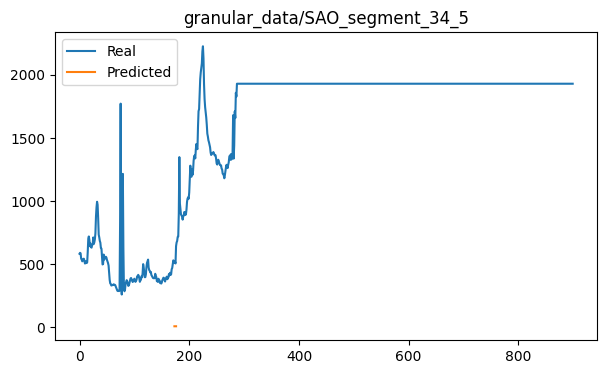

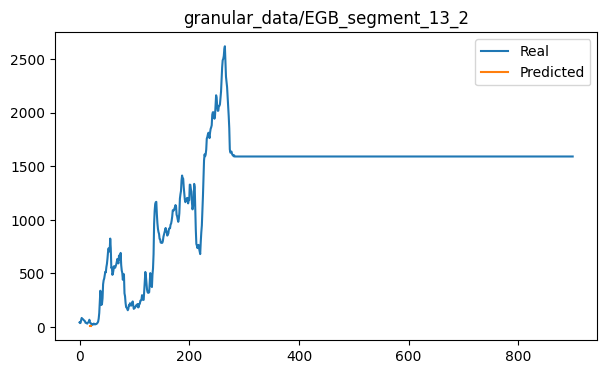

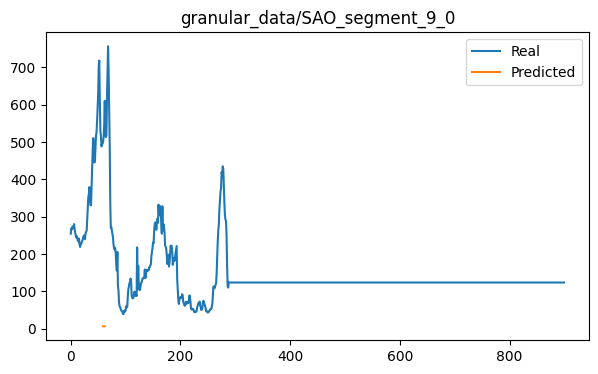

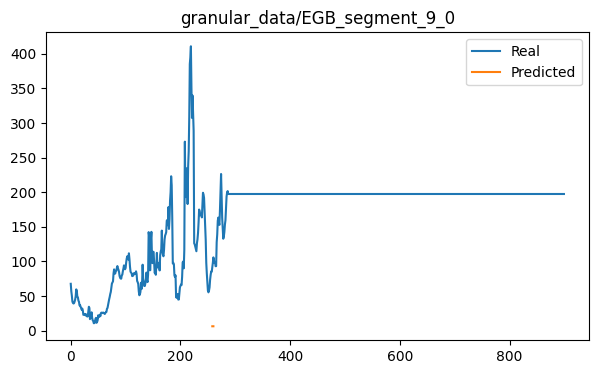

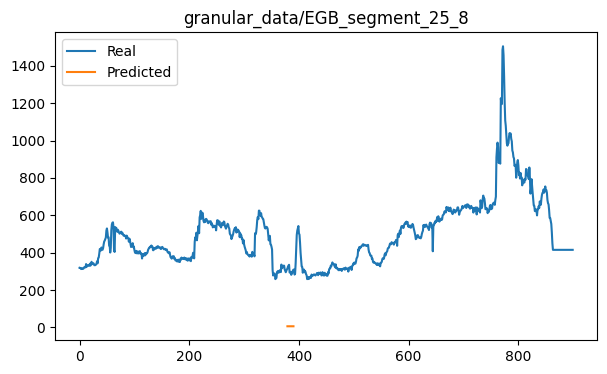

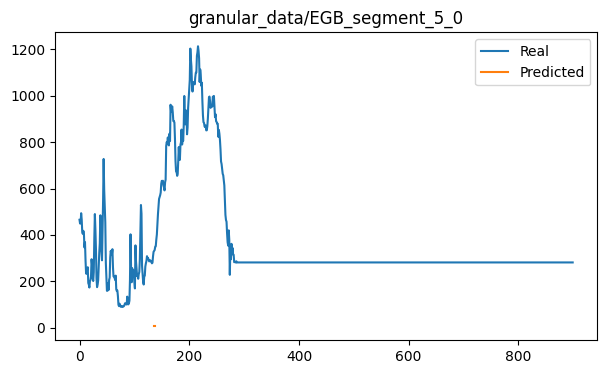

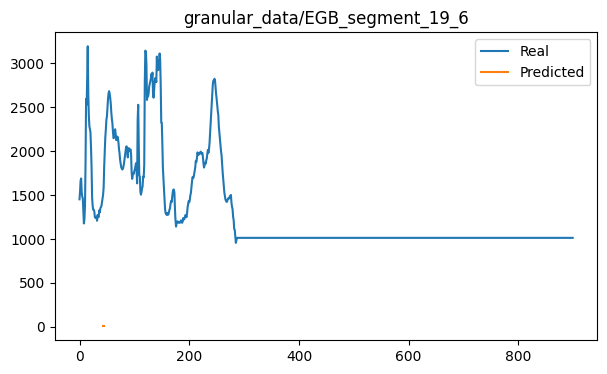

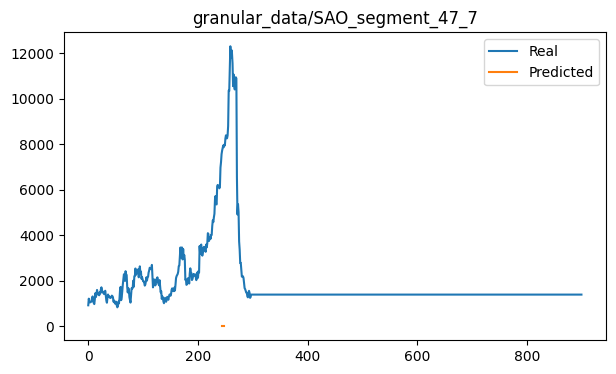

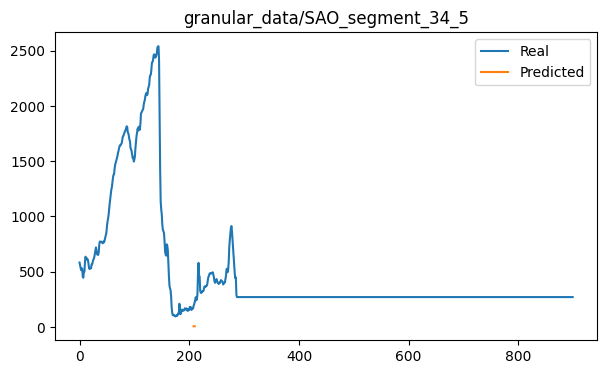

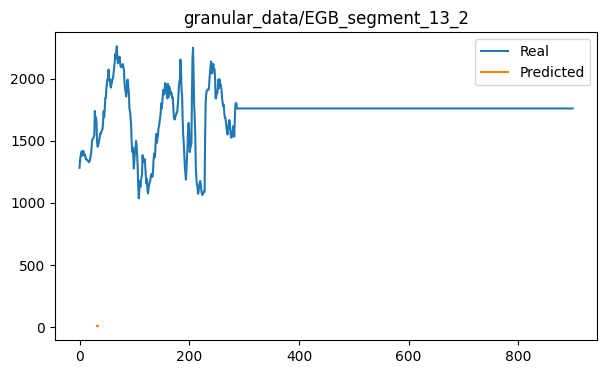

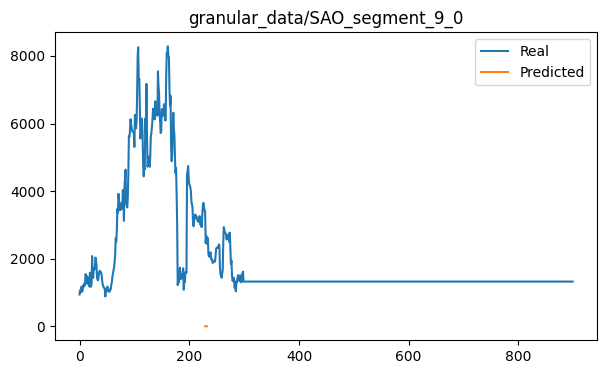

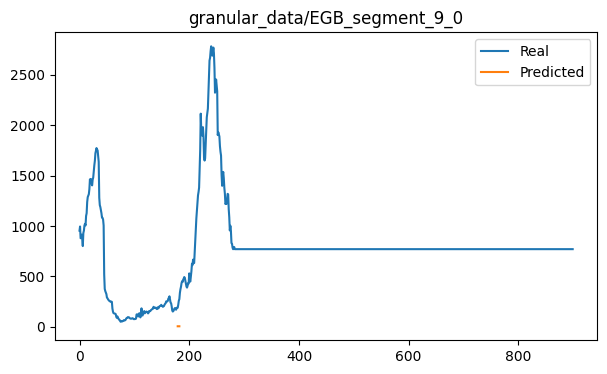

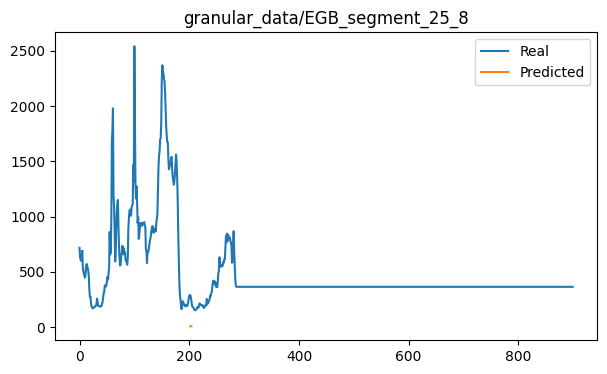

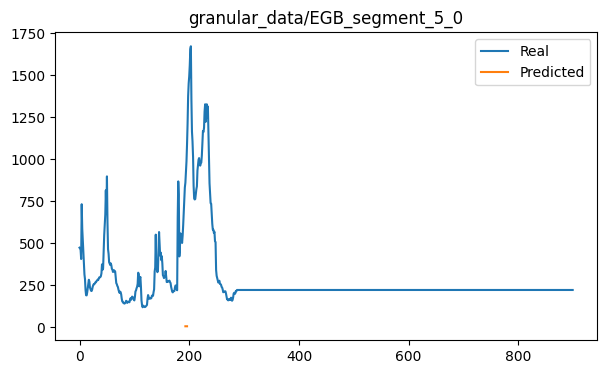

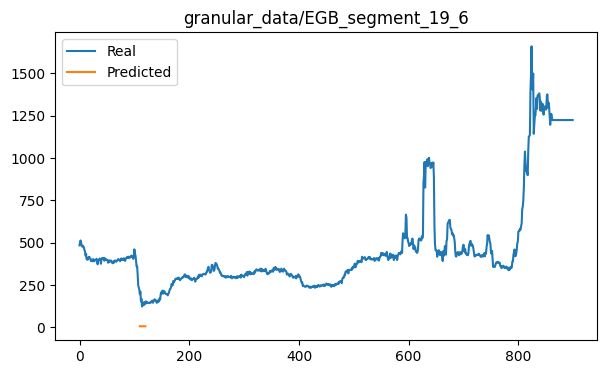

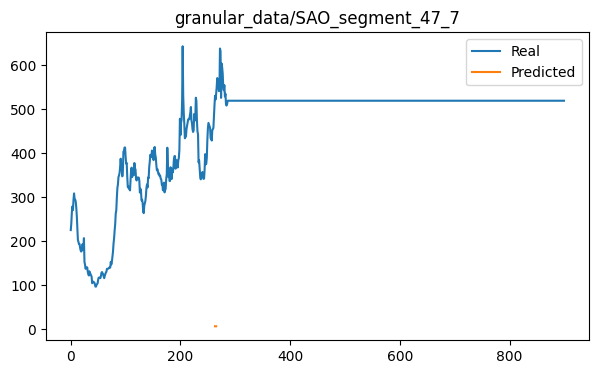

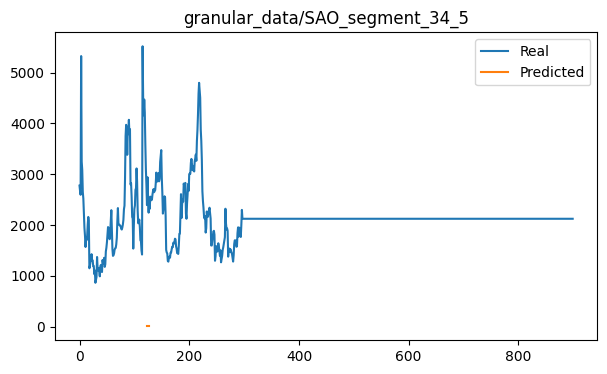

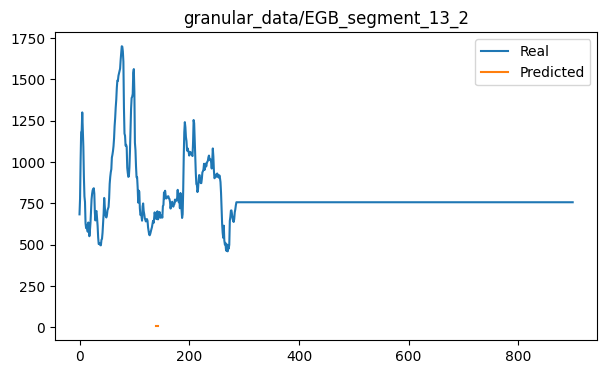

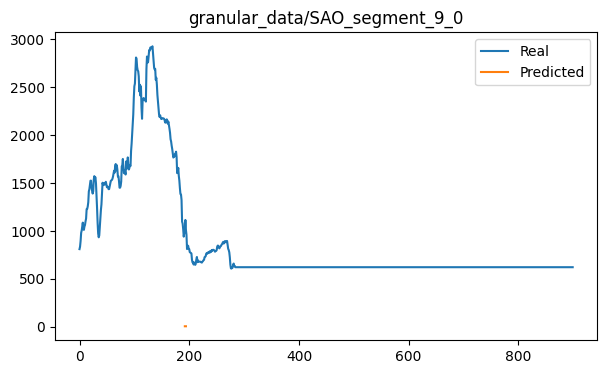

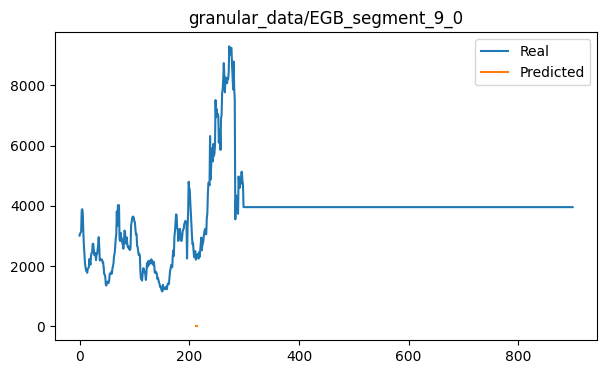

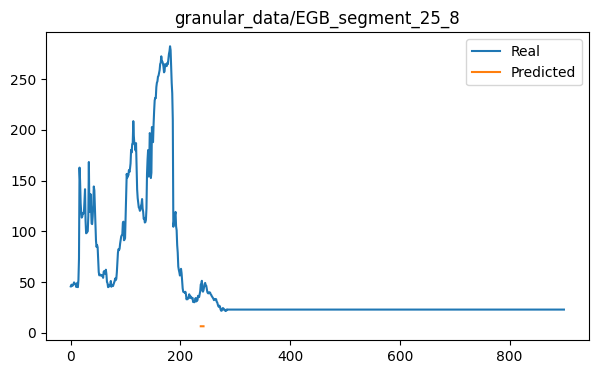

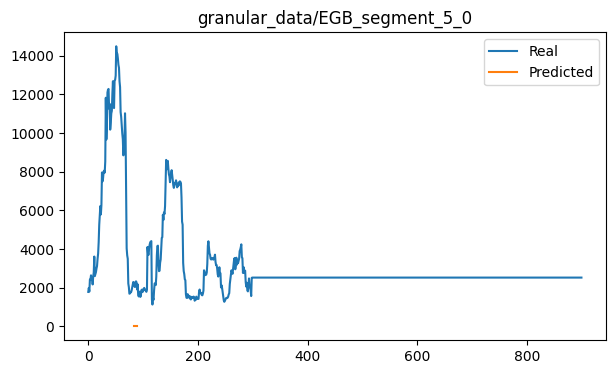

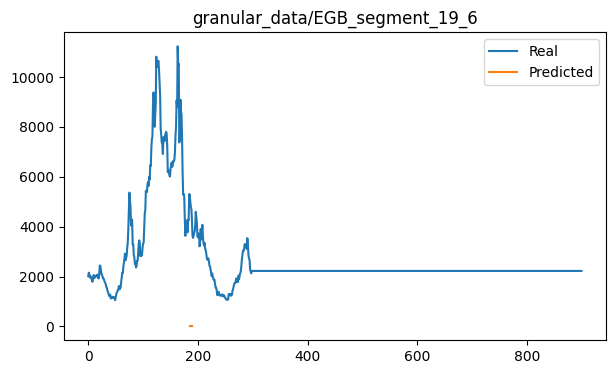

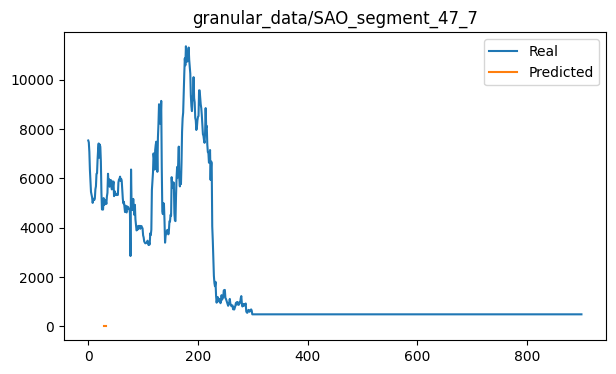

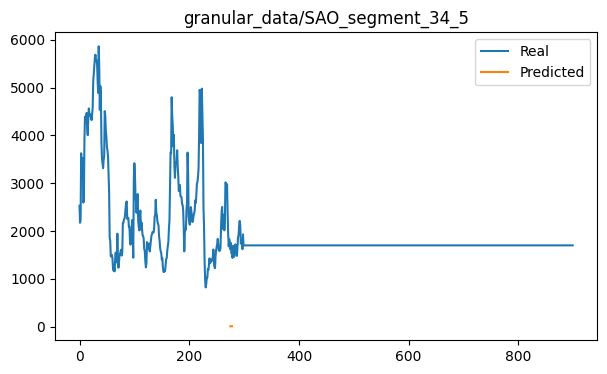

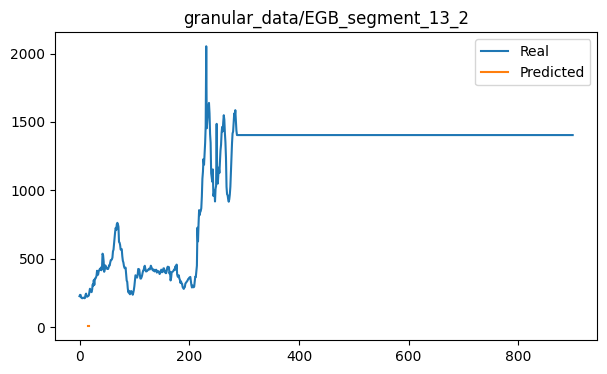

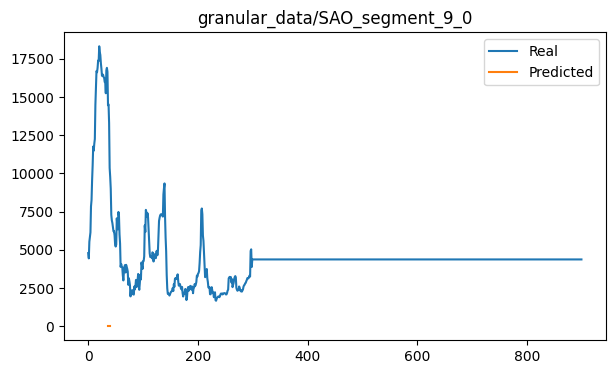

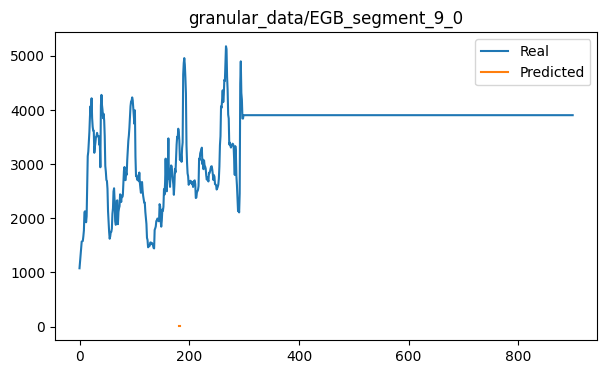

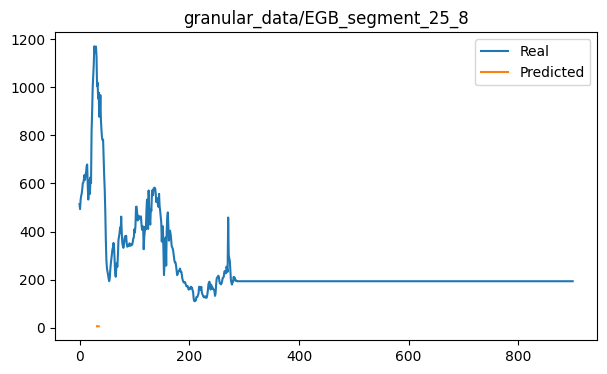

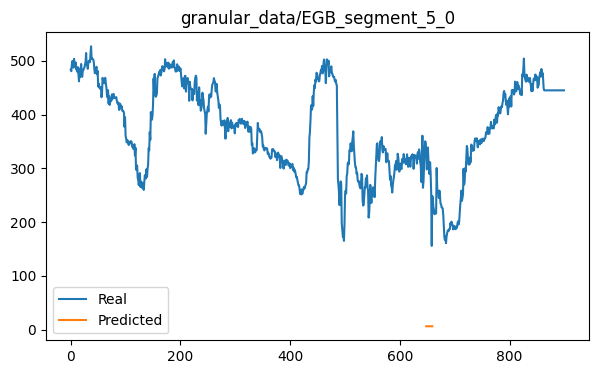

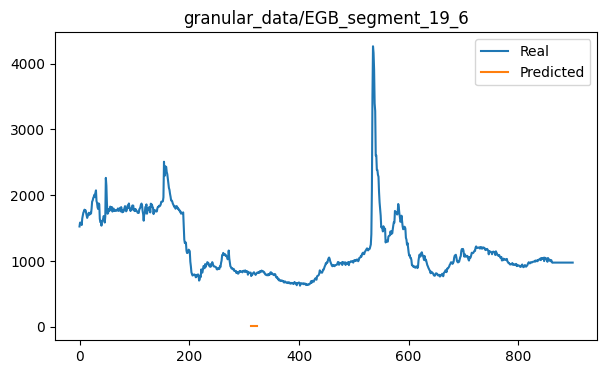

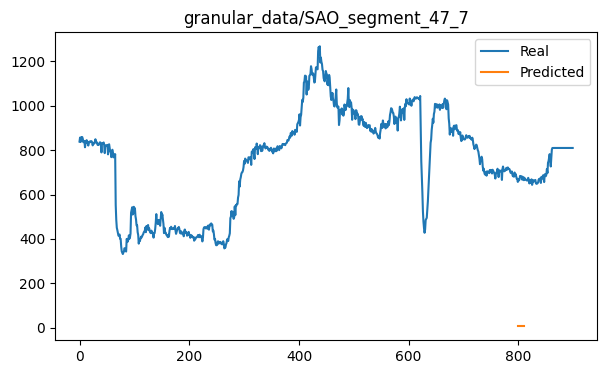

In [181]:
model.eval() # switch the model to evaluation mode

# Get a batch of data from the DataLoader
for i, batch in enumerate(train_dataloader):
    sample = batch

    # get the model's prediction
    with torch.no_grad():
        predictions = model(batch)

    # convert the tensors to numpy arrays for plotting
    mask = batch['mask'].cpu().numpy()
    targets = batch['target'].cpu().numpy()
    predictions = predictions.cpu().numpy()

    for idx in range(0, 8):
        # Get the indices where mask is zero
        indices = np.where(mask[idx] == False)

        plt.figure(figsize=(7, 4))
        plt.plot(targets[idx], label='Real')
        #plt.plot(predictions[idx], label="Complete")
        plt.plot(indices[0], predictions[idx][indices],label='Predicted')
        plt.title(dataset.directories[test_dataset.indices[idx]])
        plt.legend()
        plt.show()
        
    if i == 3:
        break